In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import pydicom
from random import sample
from itertools import chain

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1497,00007810_006.png,No Finding,6,7810,039Y,F,PA,2500,2048,0.168,0.168,/data/images_004/images/00007810_006.png
2575,00012907_017.png,Infiltration,17,12907,044Y,M,PA,2992,2991,0.143,0.143,/data/images_006/images/00012907_017.png
2480,00012475_000.png,Atelectasis|Infiltration,0,12475,033Y,M,PA,2992,2991,0.143,0.143,/data/images_006/images/00012475_000.png


# Exploratory Data Analysis (EDA)

In [3]:
number_of_data_points = len(all_xray_df)
number_of_data_points

112120

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <a list of 10 Patch objects>)

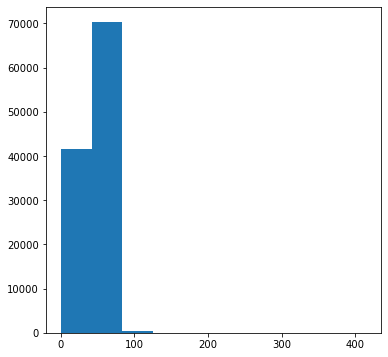

In [4]:
#Patient Age
age_data = all_xray_df['Patient Age']
plt.figure(figsize=(6,6))
plt.hist(age_data)


(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

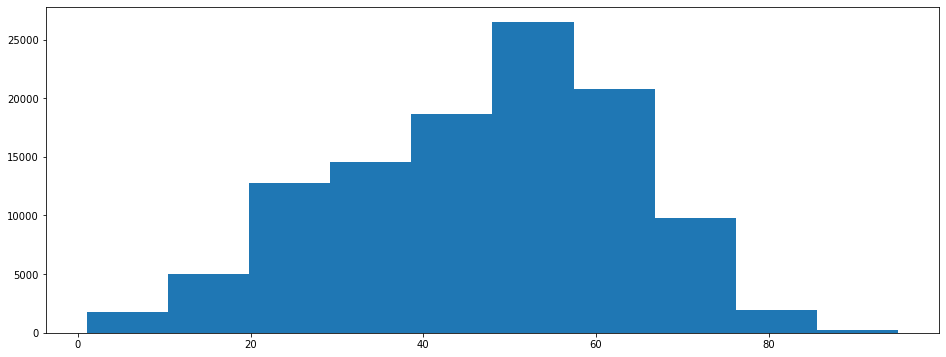

In [5]:
#It seems from the above plot, there may be some age values that are either outliers, 
#or represent data that has been entered incorrectly
age_data_filtered = [age for age in age_data if age < 100]
len(age_data_filtered) #112104 values
min_val = min(age_data_filtered)
#min age is 1 years old
max_val = max(age_data_filtered)
#max age is 95 years old

plt.figure(figsize=(16,6))
plt.hist(age_data_filtered)


(array([63340.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 48780.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

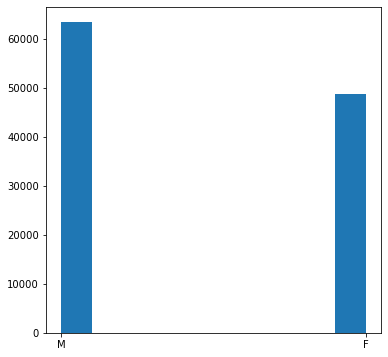

In [6]:
#Patient Gender
plt.figure(figsize=(6,6))
plt.hist(all_xray_df['Patient Gender'])

In [7]:
#From the above plot it seems there are more images of male patients, however, the number of images of
#female patients is about 10,000 less than the number of male patients, so it would seem the 
#number of male and female patients imaged is roughly similar

(array([67310.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 44810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

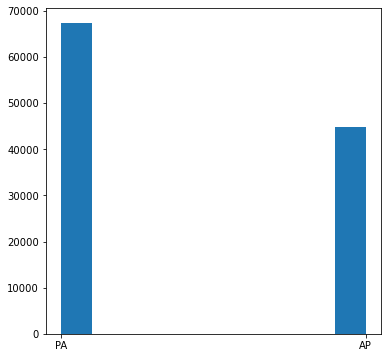

In [8]:
#View Positions reported
plt.figure(figsize=(6,6))
plt.hist(all_xray_df['View Position'])

In [9]:
#The two view positions captured in images are posteroanterior(PA) and anteroposterior(AP)

In [10]:
# Looking at different labels and set a binary flag(0,1) for for each disease to assist in understanding the
# occurrence of each disease
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for label in all_labels:
    if len(label)>1: 
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [11]:
all_xray_df[all_labels].sum()/len(all_xray_df)
#leads to 15 label categories with the following frequency

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images for Label')]

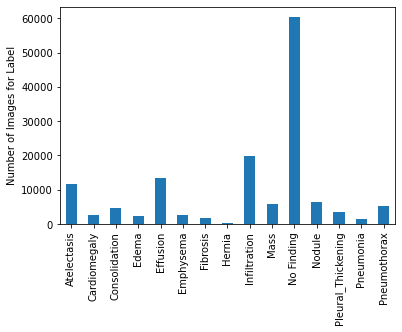

In [12]:
#Plot of the count for each label
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images for Label')

In [13]:
#Pneumonia count
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30]

Pneumonia                                          322
Infiltration|Pneumonia                             199
Edema|Infiltration|Pneumonia                       137
Atelectasis|Pneumonia                              108
Edema|Pneumonia                                     83
Effusion|Pneumonia                                  54
Effusion|Infiltration|Pneumonia                     42
Consolidation|Pneumonia                             36
Atelectasis|Infiltration|Pneumonia                  34
Atelectasis|Effusion|Pneumonia                      23
Edema|Effusion|Infiltration|Pneumonia               21
Nodule|Pneumonia                                    19
Edema|Effusion|Pneumonia                            19
Atelectasis|Effusion|Infiltration|Pneumonia         18
Atelectasis|Consolidation|Pneumonia                 15
Consolidation|Infiltration|Pneumonia                13
Mass|Pneumonia                                      11
Pleural_Thickening|Pneumonia                        11
Infiltrati

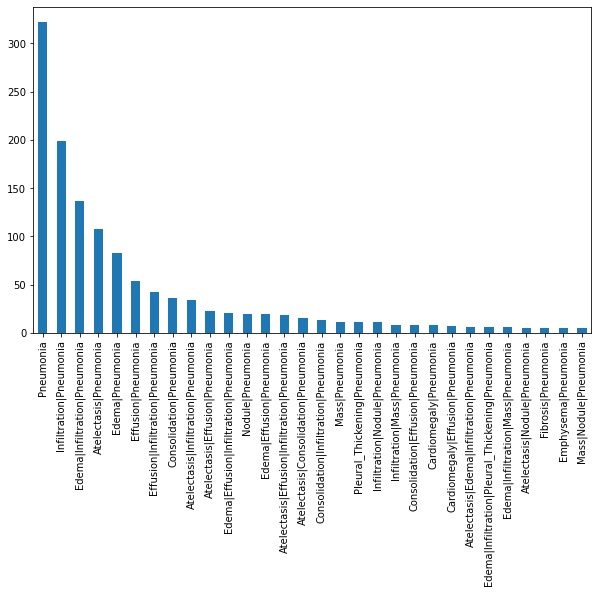

In [14]:
#Plot of the count for the Pneumonia findings with comorbidities, 30 most common
plt.figure(figsize=(10,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')


In [15]:
pneumonia_total = sum(all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts())
pneumonia_total


1431

In [16]:
#From the above we can see Pneumonia appears 1431 times for the finding labels 

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

<Figure size 720x432 with 0 Axes>

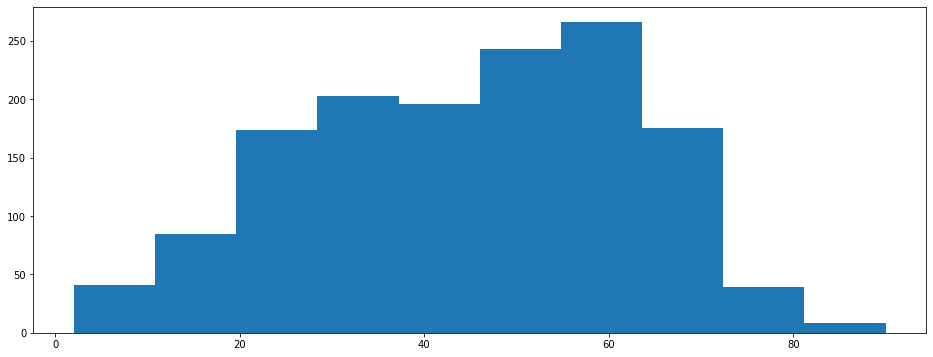

In [17]:
#Here is the data for Pneumonia cases with respect to Patient Age
plt.figure(figsize=(10,6))
pneumonia_ages = all_xray_df[all_xray_df.Pneumonia==1]['Patient Age']
pn_age_data_filtered = [age for age in pneumonia_ages if age < 100]
len(pn_age_data_filtered) #1430 values

min_val = min(pn_age_data_filtered) #min age is 2 years old
max_val = max(pn_age_data_filtered) #max age is 90 years old

plt.figure(figsize=(16,6))
plt.hist(pn_age_data_filtered)


(array([838.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

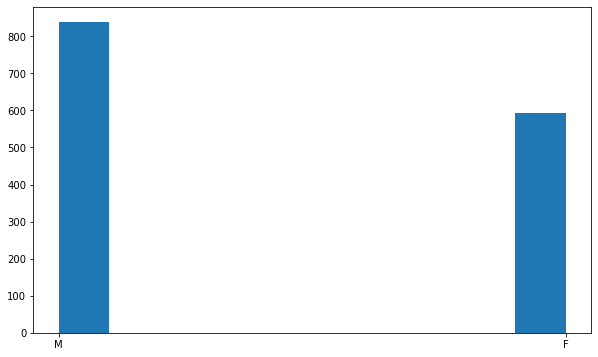

In [18]:
#Here is the data for Pneumonia cases with respect to Patient Gender
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'])

(array([801.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 630.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

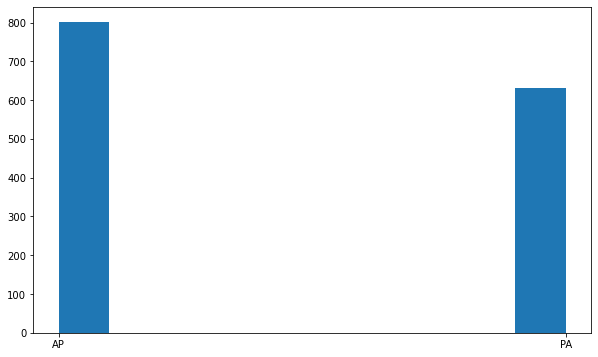

In [19]:
#Here is the data for Pneumonia cases with respect to the two views
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['View Position'])

In [20]:
#Non-pneumonia image count, 30 most common findings
all_xray_df[all_xray_df.Pneumonia==0]['Finding Labels'].value_counts()[0:30]

No Finding                           60361
Infiltration                          9547
Atelectasis                           4215
Effusion                              3955
Nodule                                2705
Pneumothorax                          2194
Mass                                  2139
Effusion|Infiltration                 1603
Atelectasis|Infiltration              1350
Consolidation                         1310
Atelectasis|Effusion                  1165
Pleural_Thickening                    1126
Cardiomegaly                          1093
Emphysema                              892
Infiltration|Nodule                    829
Atelectasis|Effusion|Infiltration      737
Fibrosis                               727
Edema                                  628
Cardiomegaly|Effusion                  484
Consolidation|Infiltration             441
Infiltration|Mass                      420
Effusion|Pneumothorax                  403
Effusion|Mass                          402
Atelectasis

In [21]:
non_pneumonia_total = sum(all_xray_df[all_xray_df.Pneumonia==0]['Finding Labels'].value_counts())
non_pneumonia_total

110689

In [22]:
#From the above we can see findings other than Pneumonia appear 110689 times

In [23]:
#All unique patient IDs
unique_patients = all_xray_df.groupby(['Patient ID']).sum(numeric_only= True)

#Sum all diseases for each unique patient
unique_patients['Disease Totals'] = unique_patients[all_labels].iloc[:].sum(axis=1)
unique_patients

,Follow-up #,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,Consolidation,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Disease Totals
Patient ID,,,,,,,,,,,,,,,,,,,,,
1,3,174,8076,7526,0.454,0.454,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0,81,2500,2048,0.171,0.171,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,28,620,20588,21465,1.219,1.219,0.0,0.0,0.0,0.0,...,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
4,0,82,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
5,28,556,21098,21241,1.219,1.219,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30801,1,78,4548,4548,0.336,0.336,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0
30802,0,29,2048,2500,0.168,0.168,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
30803,0,42,2048,2500,0.168,0.168,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Image Analysis

In [24]:
pneumonia_cases = sample_df[sample_df["Finding Labels"]=="Pneumonia"]
pneumonia_cases

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,0.171,/data/images_004/images/00008470_008.png
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,0.168,/data/images_006/images/00011702_043.png
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,0.143,/data/images_006/images/00012158_025.png
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,0.143,/data/images_006/images/00012667_000.png
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,0.143,/data/images_006/images/00012733_000.png
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,0.143,/data/images_007/images/00014201_008.png
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,0.139,/data/images_008/images/00017714_019.png
3858,00019021_001.png,Pneumonia,1,19021,044Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00019021_001.png
4033,00019865_013.png,Pneumonia,13,19865,022Y,M,PA,2786,2739,0.143,0.143,/data/images_009/images/00019865_013.png
4282,00021127_018.png,Pneumonia,18,21127,065Y,M,PA,2992,2991,0.143,0.143,/data/images_010/images/00021127_018.png


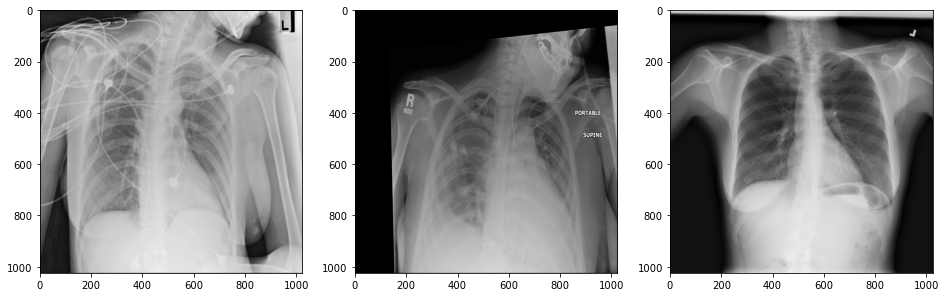

In [55]:
#Select the first 3 cases from the Pneumonia cases
#Create numpy array of pixel values
plt.figure(figsize=(16, 16))

pneumo_imgs = pneumonia_cases[0:3]["path"].values
pneumo_imgs_list = []
for img in pneumo_imgs:
    im_pneumo = plt.imread(img)
    im_pneumo = im_pneumo.astype('float64')
    pneumo_imgs_list.append(im_pneumo)

#Original image plots
plt.subplot(131)
plt.imshow(pneumo_imgs_list[0], cmap="gray")
plt.subplot(132)
plt.imshow(pneumo_imgs_list[1], cmap="gray")
plt.subplot(133)
plt.imshow(pneumo_imgs_list[2], cmap="gray")

In [58]:
#Normalize the pixel arrays
pneumo_imgs_list_norm = []
for im in pneumo_imgs_list:
    mean_intensity = np.mean(im)
    std_intensity = np.std(im)
    new_img = im.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    pneumo_imgs_list_norm.append(new_img)

(array([1.3459e+04, 1.1620e+03, 1.1440e+03, 1.5210e+03, 1.8070e+03,
        2.3550e+03, 2.7160e+03, 3.6000e+03, 4.4960e+03, 5.4240e+03,
        5.9980e+03, 6.9900e+03, 8.2960e+03, 1.0516e+04, 1.0169e+04,
        1.2168e+04, 1.6128e+04, 1.1246e+05, 1.5195e+04, 2.5500e+03,
        2.2910e+03, 1.8340e+03, 1.5830e+03, 1.5360e+03, 1.4970e+03,
        1.4490e+03, 1.3860e+03, 1.4200e+03, 1.3570e+03, 1.3650e+03,
        1.3750e+03, 1.3990e+03, 1.3960e+03, 1.3750e+03, 1.5110e+03,
        1.4740e+03, 1.6280e+03, 1.6920e+03, 1.7600e+03, 1.8870e+03,
        2.0590e+03, 2.0940e+03, 2.2200e+03, 2.3560e+03, 2.4350e+03,
        2.4810e+03, 2.6280e+03, 2.7500e+03, 2.9820e+03, 3.2360e+03,
        3.2730e+03, 3.3900e+03, 3.3520e+03, 3.2530e+03, 3.3020e+03,
        3.3810e+03, 3.3980e+03, 3.4720e+03, 3.7400e+03, 3.9010e+03,
        3.9220e+03, 3.9220e+03, 3.8150e+03, 3.9170e+03, 4.0040e+03,
        4.0420e+03, 3.8790e+03, 3.7930e+03, 4.0490e+03, 3.9240e+03,
        4.0130e+03, 4.1090e+03, 4.2360e+03, 4.33

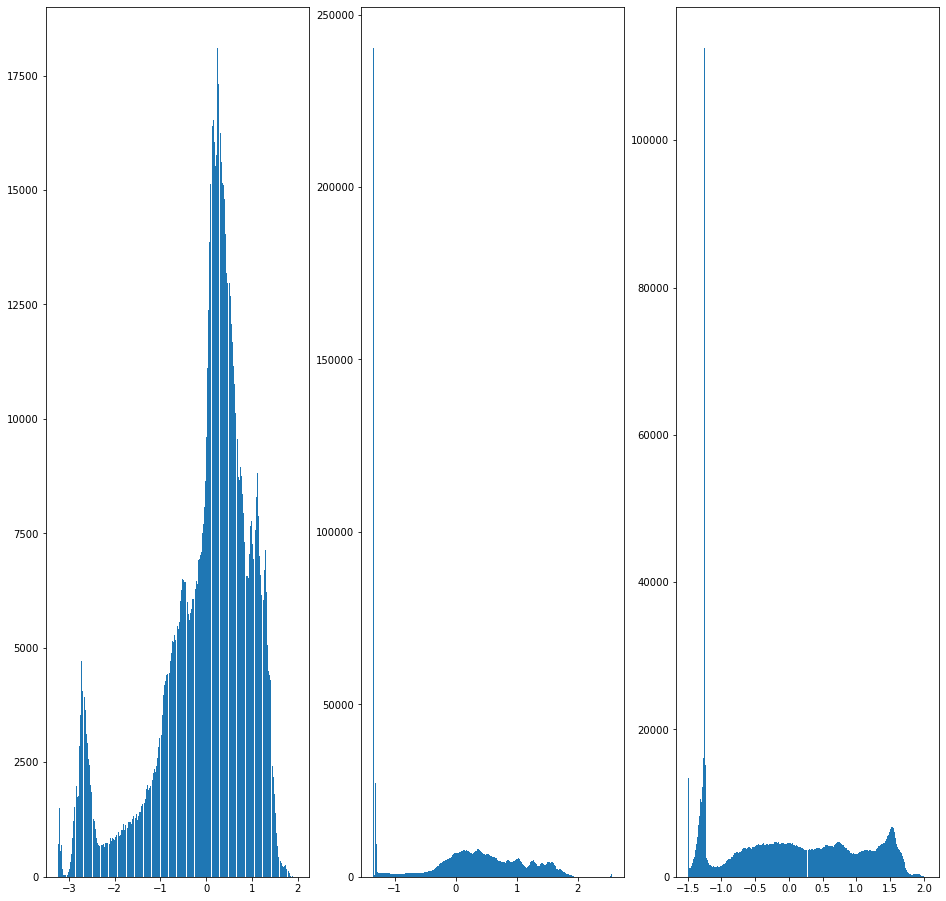

In [60]:
#plot of the pixel densities for Pneumonia cases
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.hist(pneumo_imgs_list_norm[0].ravel(), bins = 256)
plt.subplot(132)
plt.hist(pneumo_imgs_list_norm[1].ravel(), bins = 256)
plt.subplot(133)
plt.hist(pneumo_imgs_list_norm[2].ravel(), bins = 256)


In [61]:
#Here are cases where there was no finding
nf_cases = sample_df[sample_df["Finding Labels"]=="No Finding"]
nf_cases

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000017_001.png
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000042_002.png
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000057_001.png
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,0.139000,/data/images_001/images/00000061_019.png
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,0.194311,/data/images_001/images/00000080_005.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5597,00030639_001.png,No Finding,1,30639,061Y,M,AP,3056,2544,0.139000,0.139000,/data/images_012/images/00030639_001.png
5600,00030704_000.png,No Finding,0,30704,052Y,F,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030704_000.png
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,/data/images_012/images/00030712_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,/data/images_012/images/00030792_000.png


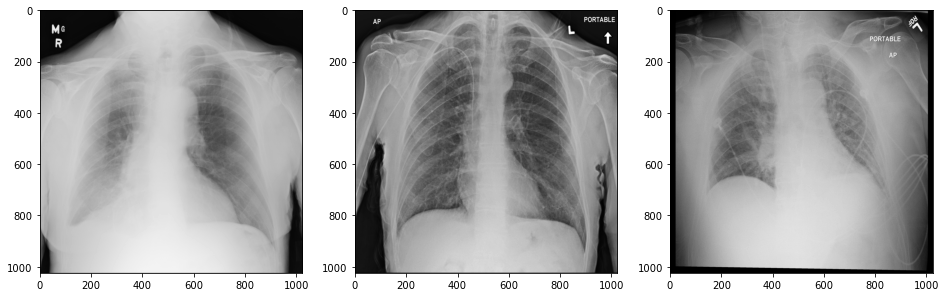

In [62]:
#Select the first 3 cases from the No Finding cases
#Create numpy array of pixel values
plt.figure(figsize=(16, 16))

nf_imgs = nf_cases[0:3]["path"].values
nf_imgs_list = []
for img in nf_imgs:
    im_nf = plt.imread(img)
    im_nf = im_nf.astype('float64')
    nf_imgs_list.append(im_nf)

#Original image plots
plt.subplot(131)
plt.imshow(nf_imgs_list[0], cmap="gray")
plt.subplot(132)
plt.imshow(nf_imgs_list[1], cmap="gray")
plt.subplot(133)
plt.imshow(nf_imgs_list[2], cmap="gray")

In [65]:
#Normalize the pixel arrays
nf_imgs_list_norm = []
for im in nf_imgs_list:
    mean_intensity = np.mean(im)
    std_intensity = np.std(im)
    new_img = im.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    nf_imgs_list_norm.append(new_img)

(array([5.8090e+04, 2.4870e+03, 6.7400e+02, 6.0200e+02, 4.8800e+02,
        4.1500e+02, 3.1800e+02, 3.2300e+02, 2.5600e+02, 2.8300e+02,
        3.1600e+02, 3.5900e+02, 4.8500e+02, 6.1300e+02, 6.5000e+02,
        7.9900e+02, 7.9300e+02, 9.2400e+02, 9.1700e+02, 8.8400e+02,
        7.9600e+02, 7.2200e+02, 8.1200e+02, 9.7200e+02, 9.4600e+02,
        1.0110e+03, 1.0310e+03, 1.0260e+03, 9.7500e+02, 8.5700e+02,
        8.0000e+02, 7.5100e+02, 7.4800e+02, 7.1800e+02, 7.1400e+02,
        7.7500e+02, 7.6900e+02, 7.6100e+02, 7.6100e+02, 7.9700e+02,
        8.2200e+02, 7.7300e+02, 9.1900e+02, 9.7900e+02, 1.0310e+03,
        1.0200e+03, 1.0180e+03, 1.0160e+03, 1.0530e+03, 1.1060e+03,
        1.1850e+03, 1.1910e+03, 1.1890e+03, 1.2350e+03, 1.1670e+03,
        1.3550e+03, 1.2060e+03, 1.2850e+03, 1.2990e+03, 1.3510e+03,
        1.2970e+03, 1.4340e+03, 1.4620e+03, 1.5830e+03, 1.5290e+03,
        1.4880e+03, 1.6210e+03, 1.5200e+03, 1.5430e+03, 1.5000e+03,
        1.4580e+03, 1.4210e+03, 1.4320e+03, 1.45

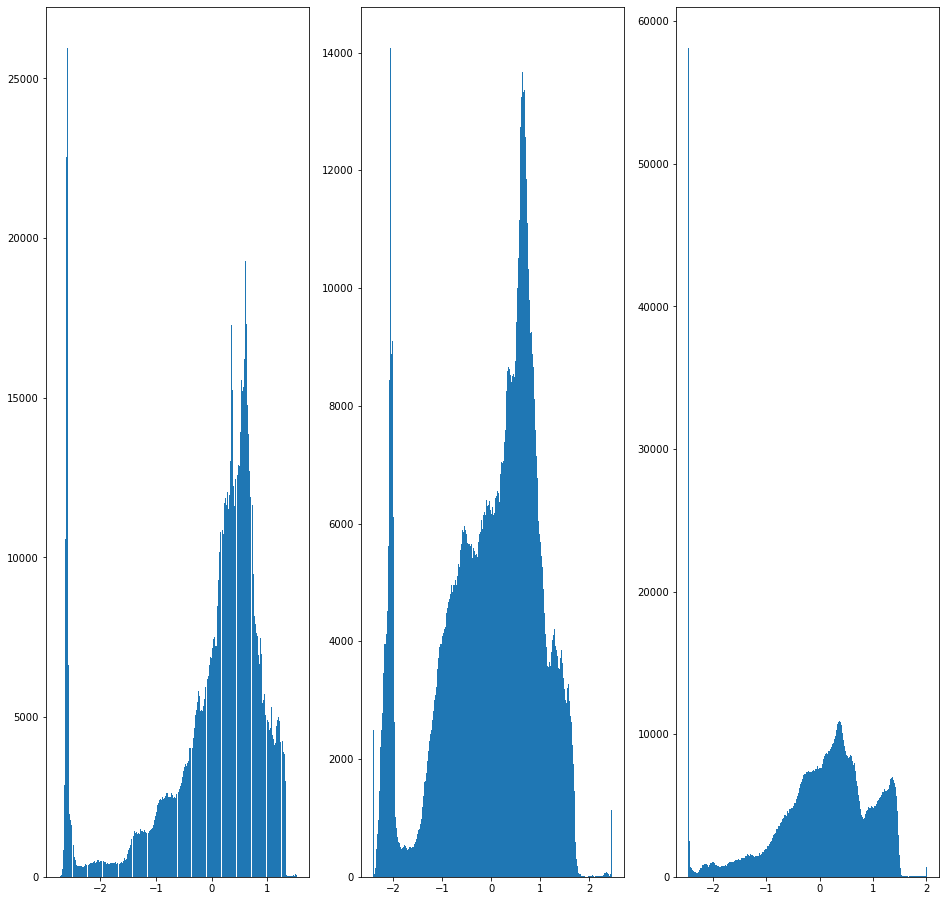

In [68]:
#plot of the pixel densities for cases with No Finding
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.hist(nf_imgs_list_norm[0].ravel(), bins = 256)
plt.subplot(132)
plt.hist(nf_imgs_list_norm[1].ravel(), bins = 256)
plt.subplot(133)
plt.hist(nf_imgs_list_norm[2].ravel(), bins = 256)

In [70]:
#Here are cases for Infiltration
infiltration_cases = sample_df[sample_df["Finding Labels"]=="Infiltration"]
infiltration_cases

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
32,00000181_017.png,Infiltration,17,181,050Y,F,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000181_017.png
33,00000181_035.png,Infiltration,35,181,050Y,F,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000181_035.png
44,00000246_011.png,Infiltration,11,246,051Y,M,PA,3056,2544,0.139000,0.139000,/data/images_001/images/00000246_011.png
48,00000250_005.png,Infiltration,5,250,050Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000250_005.png
51,00000268_001.png,Infiltration,1,268,049Y,M,AP,2500,2048,0.168000,0.168000,/data/images_001/images/00000268_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5543,00030220_000.png,Infiltration,0,30220,048Y,M,PA,1960,1862,0.194311,0.194311,/data/images_012/images/00030220_000.png
5573,00030430_000.png,Infiltration,0,30430,021Y,F,PA,1794,1940,0.194311,0.194311,/data/images_012/images/00030430_000.png
5578,00030471_004.png,Infiltration,4,30471,054Y,F,AP,3056,2544,0.139000,0.139000,/data/images_012/images/00030471_004.png
5583,00030545_000.png,Infiltration,0,30545,062Y,F,PA,1743,1795,0.194314,0.194314,/data/images_012/images/00030545_000.png


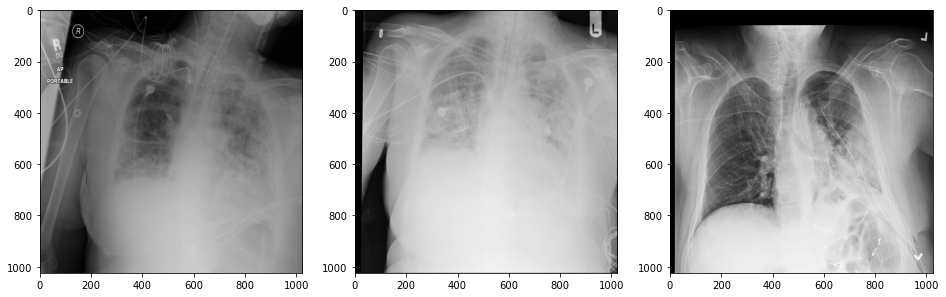

In [71]:
#Select the first 3 cases from the Infiltration cases
#Create numpy array of pixel values
plt.figure(figsize=(16, 16))

infil_imgs = infiltration_cases[0:3]["path"].values
infil_imgs_list = []
for img in infil_imgs:
    im_infil = plt.imread(img)
    im_infil = im_infil.astype('float64')
    infil_imgs_list.append(im_infil)

#Original image plots
plt.subplot(131)
plt.imshow(infil_imgs_list[0], cmap="gray")
plt.subplot(132)
plt.imshow(infil_imgs_list[1], cmap="gray")
plt.subplot(133)
plt.imshow(infil_imgs_list[2], cmap="gray")

In [72]:
#Normalize the pixel arrays
infil_imgs_list_norm = []
for im in infil_imgs_list:
    mean_intensity = np.mean(im)
    std_intensity = np.std(im)
    new_img = im.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    infil_imgs_list_norm.append(new_img)

(array([7.7553e+04, 7.7000e+01, 1.9990e+03, 9.9300e+02, 1.1060e+03,
        4.7300e+02, 3.8300e+02, 5.2500e+02, 6.0500e+02, 8.6000e+02,
        1.2290e+03, 1.3050e+03, 1.1740e+03, 1.1720e+03, 1.2820e+03,
        1.3550e+03, 1.2560e+03, 1.1690e+03, 1.1180e+03, 9.6300e+02,
        1.0340e+03, 1.0430e+03, 1.0580e+03, 1.0490e+03, 1.0870e+03,
        1.1760e+03, 1.2620e+03, 1.2330e+03, 1.2150e+03, 1.1040e+03,
        1.0050e+03, 0.0000e+00, 1.0080e+03, 1.1910e+03, 1.1090e+03,
        1.1020e+03, 1.1570e+03, 1.2160e+03, 1.0920e+03, 1.1100e+03,
        1.0760e+03, 1.1050e+03, 1.2200e+03, 1.2380e+03, 1.2300e+03,
        1.3780e+03, 1.3140e+03, 1.4700e+03, 1.5080e+03, 1.6620e+03,
        1.8320e+03, 1.7900e+03, 1.8580e+03, 2.1110e+03, 2.2360e+03,
        2.2160e+03, 2.2830e+03, 2.4540e+03, 2.6800e+03, 2.6730e+03,
        2.8340e+03, 2.8470e+03, 3.0770e+03, 0.0000e+00, 3.2570e+03,
        3.1800e+03, 3.2640e+03, 3.3290e+03, 3.4050e+03, 3.4300e+03,
        3.4250e+03, 3.3450e+03, 3.2170e+03, 3.22

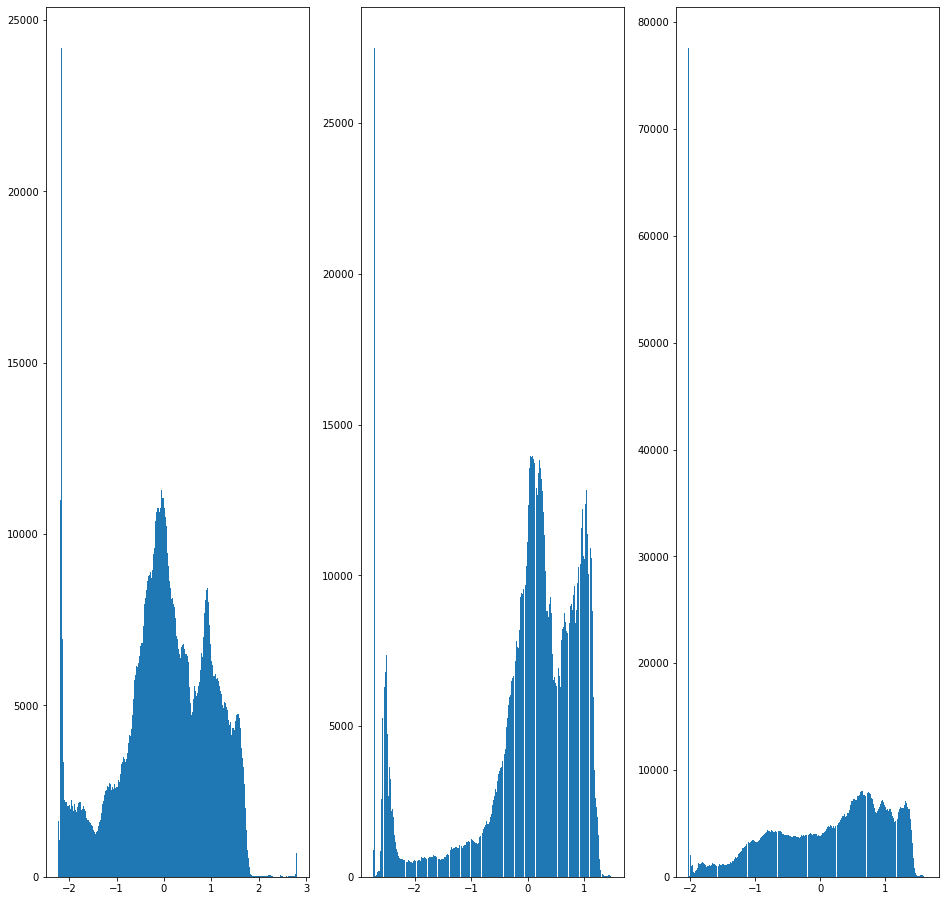

In [73]:
#plot of the pixel densities for Infiltration cases
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.hist(infil_imgs_list_norm[0].ravel(), bins = 256)
plt.subplot(132)
plt.hist(infil_imgs_list_norm[1].ravel(), bins = 256)
plt.subplot(133)
plt.hist(infil_imgs_list_norm[2].ravel(), bins = 256)

### Image Analysis Findings
From the Pneumonia, No Finding and Infiltration case pixel intensity plots it can be observed that some of the
Pneumonia, No Finding and Infiltration case contain an initial pixel intensity spike between a normalized value of -1 and -3, this is most likely due to the image border present in these images.
The three Pneumonia cases having varying pixel intensities. The first case depicts a peak of 17500 at a normalized value of 0, whereas for the other two Pneumonia cases it is hard to tell where the second peak occurs because the image border intensity is so strong, however it does seem that the second highest intensity peak in the second Pneumonia case could be around a normalized value of 0 like in the first case and have a peak instensity close to 20000, whereas in the third Pneumonia case the second peak is around a normalized value of 1.5 with a peak instensity of 10000. This variation in pixel intensity could indicate why it may be difficult for trained clinicians to correctly identify Pneumonia in chest X-rays.
The first case with No Finding has a spike close to 20000 at a normalized value of approximately .6. The shapes
of the intensity plots for the Pneumonia case and the case with No Finding are also very similar. This observation of
the similarity of pixel instensities could also indicate why it is difficult to infer Pneumonia from a chest X-ray, since the captured x-ray presents in a similar fashion to a supposed case with no Finding. The other two no finding cases have a similar pixel intensity profiles to the first no finding cases, with there second peaks close to a normalized value of 0.5, however the pixel intensities of those second peaks are much less than the first no finding case.
Lastly the first two Infiltration cases have pixel profiles that are different than the Pneumonia and no find cases, with pixel intensity peaks at normalized values of zero and one, having intensity values between 10000 and 15000. The last Infiltration case has pixel intensity profile that is different from its predecessors, and shows the most similarity to the Pneumonia and no finding cases. This case has a pixel intensity peak at normalized value of around 0.75, but with a pixel intensity less than 10000.


## Exploratory Data Analysis Findings

The above exploratory data analysis depicts of the NIH chest x-ray dataset depicts that only 1431 out of a possible 112120 data points indicate findings of Pneumonia, or about 1.2% of all the data. 
Aside from some outlier age data points findings, the ages of patients presenting with Pneumonia within the NIH dataset are inline with the distribution of ages in the general NIH dataset.
Although the data depicts slighlty more male patients, the patient gender distribution is close to half male and half female. Image viewing positions captured in the NIH dataset are predemoninantly posteroanterior(PA) and anteroposterior(AP).
From the Pneumonia, No Finding and Infiltration case pixel intensity plots it can be observed that some of the
Pneumonia, No Finding and Infiltration case contain an initial pixel intensity spike between a normalized value of -1 and -3, this is most likely due to the image border present in these images.
The three Pneumonia cases having varying pixel intensities. The first case depicts a peak of 17500 at a normalized value of 0, whereas for the other two Pneumonia cases it is hard to tell where the second peak occurs because the image border intensity is so strong, however it does seem that the second highest intensity peak in the second Pneumonia case could be around a normalized value of 0 like in the first case and have a peak instensity close to 20000, whereas in the third Pneumonia case the second peak is around a normalized value of 1.5 with a peak instensity of 10000. This variation in pixel intensity could indicate why it may be difficult for trained clinicians to correctly identify Pneumonia in chest X-rays.
The first case with No Finding has a spike close to 20000 at a normalized value of approximately .6. The shapes
of the intensity plots for the Pneumonia case and the case with No Finding are also very similar. This observation of
the similarity of pixel instensities could also indicate why it is difficult to infer Pneumonia from a chest X-ray, since the captured x-ray presents in a similar fashion to a supposed case with no Finding. The other two no finding cases have a similar pixel intensity profiles to the first no finding cases, with there second peaks close to a normalized value of 0.5, however the pixel intensities of those second peaks are much less than the first no finding case.
Lastly the first two Infiltration cases have pixel profiles that are different than the Pneumonia and no find cases, with pixel intensity peaks at normalized values of zero and one, having intensity values between 10000 and 15000. The last Infiltration case has pixel intensity profile that is different from its predecessors, and shows the most similarity to the Pneumonia and no finding cases. This case has a pixel intensity peak at normalized value of around 0.75, but with a pixel intensity less than 10000.


Based on the exploratory data analysis and following the 80/20 principle for training a deep learning model on chest x-rays, about 90,000 images could be used for training, with the majority of cases containing Pneumonia findings appearing in the training set. However the training set would have to be paired down to make the number of Pneumonia cases equal to the number of cases without Pneumonia. The validation set could then contain the remainder of images from the NIH dataset and fewer images with Pneumonia findings.  
